In [1]:
import numpy as np
import pandas as pd
import os
import pathlib

# data viz
from matplotlib import pyplot as plt
import seaborn as sns           # for nicer plots
sns.set(style="darkgrid")       # default style

# sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

# tf
import tensorflow as tf
from tensorflow.keras import initializers

# Step 1: Data Ingestion

Available at `02-choose-trgt-and-preprocess-imputemeansubgr-smotenc-sa.ipynb` notebook

# Step 2: Data Preprocessing

Available at `02-choose-trgt-and-preprocess-imputemeansubgr-smotenc-sa.ipynb` notebook

# Step 3: Exploratory Data Analysis

Available at `03-eda-imputemeansubgr-smotenc-sa.ipynb` notebook

# Step 4: Consider Feature Selection

Exploration of feature selection using pearson correlation and feature importance are available in `04-feature-select-imputemeansubgr-smontenc-sa.ipynb` notebook. Since we have over 51,500 samples to feature ratio, we will use all features from Step 2 in model building.

# Step 5: Modeling (FFNN)

`load preprocessed data`

In [2]:
DATA_PATH = '../data/processed/'
FILE_NAME = 'fpafod_scaled.npz'

fpafod = np.load(DATA_PATH+FILE_NAME)

X_train_res_std = fpafod['X_train_res_std']
Y_train_resampled = fpafod['Y_train_resampled']
X_val_std = fpafod['X_val_std']
Y_val = fpafod['Y_val']
X_test_std = fpafod['X_test_std']
Y_test = fpafod['Y_test']

print(f"\nShape of X_train_resampled: {X_train_res_std.shape}")
print(f"Shape of X_val: {X_val_std.shape}")
print(f"Shape of X_test: {X_test_std.shape}")

print(f"\nShape of Y_train_resampled: {Y_train_resampled.shape}")
print(f"Shape of Y_val: {Y_val.shape}")
print(f"Shape of Y_test: {Y_test.shape}")


Shape of X_train_resampled: (5380328, 104)
Shape of X_val: (460504, 104)
Shape of X_test: (460505, 104)

Shape of Y_train_resampled: (5380328,)
Shape of Y_val: (460504,)
Shape of Y_test: (460505,)


#### Prepare functions

In [3]:
def build_model_ffnn(n_classes,
                n_features,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='Adam',
                learning_rate=0.01,
                dropout_rate = 0.2,
                metric='metric'):
    """Build a FFNN model using Keras.
    
    Args:
    - n_classes: Number of output classes in the dataset.
    - n_features: Number of features in the dataset.
    - hidden_layer_sizes: A list with the number of units in each hidden layer.
    - activation: The activation function to use for the hidden layers.
    - optimizer: The optimizer to use (SGD, Adam).
    - learning_rate: The desired learning rate for the optimizer.
    - metric: The desired metric.

    Returns:
    model: A tf.keras model.
    """
    tf.keras.backend.clear_session()
    np.random.seed(207)
    tf.random.set_seed(207)

    model = tf.keras.Sequential()

    # first layer: input
    model.add(tf.keras.layers.Input(shape=[n_features], name='Input'))

    # hidden and dropout layers
    for idx, hidden_layer_sizes in enumerate(hidden_layer_sizes):
        model.add(tf.keras.layers.Dense(units=hidden_layer_sizes,
                                        activation=activation,
                                        name='Hidden_'+str(idx)))    
        model.add(tf.keras.layers.Dropout(rate=dropout_rate, name='Dropout_'+str(idx)))      # dropout layer
        
    # output layer
    model.add(tf.keras.layers.Dense(units=n_classes,
                                    use_bias=True,
                                    activation='softmax',
                                    # bias_initializer=tf.ones_initializer,
                                    # kernel_initializer=initializers.GlorotNormal(seed=207),
                                    name='Output'))
    
    # choose optimizer
    if optimizer=='SGD':
        chosen_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer=='Adam':
        chosen_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise 'Unsupported optimizer: %s' %optimizer
    
    # compile model
    model.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(),
        optimizer = chosen_optimizer,
        metrics = metric
    )

    return model

In [4]:
num_classes = 4
Y_train_oh = tf.keras.utils.to_categorical(Y_train_resampled, num_classes=num_classes)
Y_val_oh   = tf.keras.utils.to_categorical(Y_val,   num_classes=num_classes)

In [5]:
def plot_history_metrics(history):
    """Plot history metrics for training and validation data"""
    metric_names = ['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'prc']

    fig = plt.figure(figsize=(10,11))
    
    for i, name in enumerate(metric_names):
        val_name = f"val_{name}"
        train_hist = history.history[name]
        val_hist = history.history[val_name]

        ax = fig.add_subplot(3,2,i+1)
        plt.plot(train_hist, label='Train')
        plt.plot(val_hist, label='Val')
        plt.legend()
        ax.set_xlabel('Epochs')
        ax.set_title(name.capitalize())
    
    plt.tight_layout()
    plt.show()

In [6]:
def print_last_epoch_metrics(history):
    metric_names = ['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'prc']
    for i, name in enumerate(metric_names):
        val_name = f"val_{name}"
        train_hist = history.history[name]
        val_hist = history.history[val_name]
        print(f"---- Last epoch {name} ----")
        print(f"* Training: {train_hist[-1]: .3f}")
        print(f"* Validation: {val_hist[-1]: .3f}\n")

Training the wildfire model...


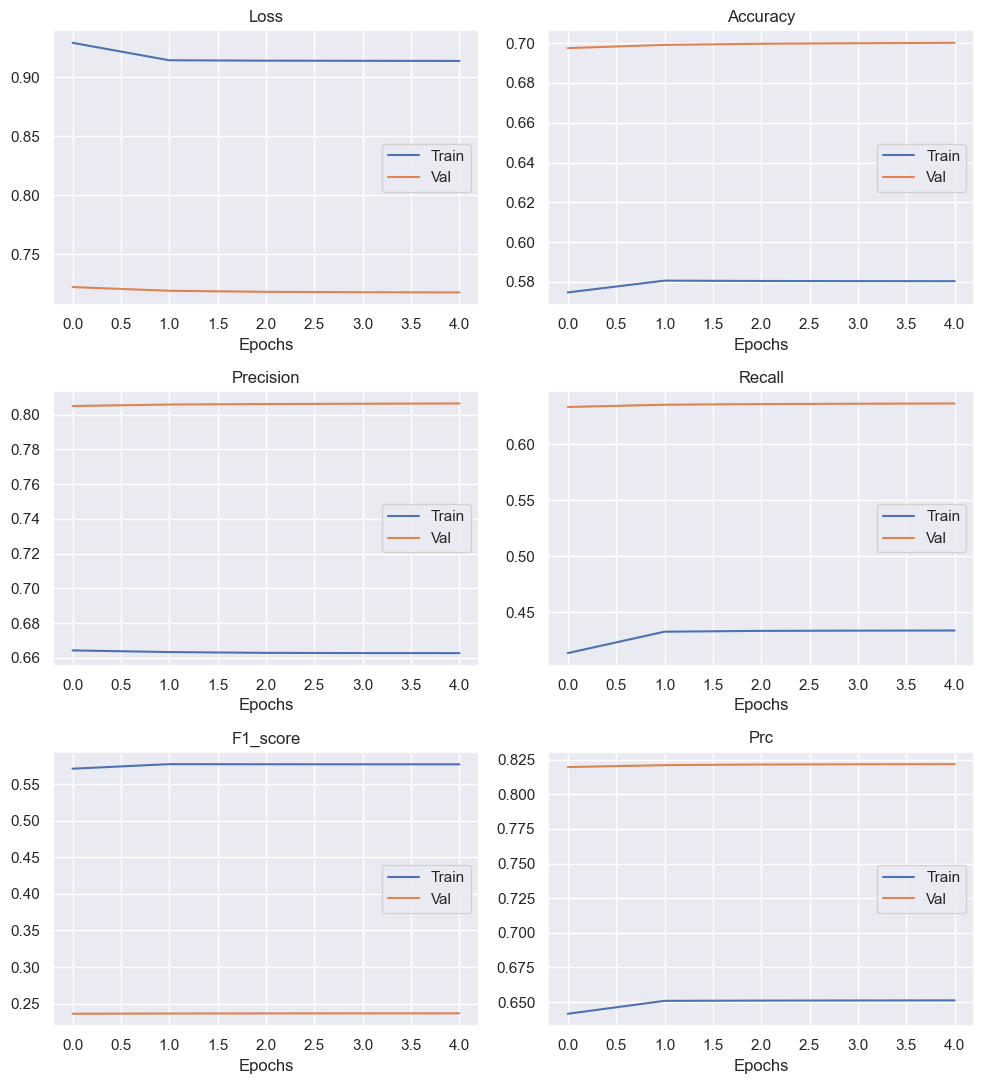

---- Last epoch loss ----
* Training:  0.914
* Validation:  0.717

---- Last epoch accuracy ----
* Training:  0.580
* Validation:  0.700

---- Last epoch precision ----
* Training:  0.663
* Validation:  0.806

---- Last epoch recall ----
* Training:  0.433
* Validation:  0.636

---- Last epoch f1_score ----
* Training:  0.577
* Validation:  0.237

---- Last epoch prc ----
* Training:  0.651
* Validation:  0.822



In [7]:
METRICS = ['accuracy', tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.F1Score(average='macro', name='f1_score'),
           tf.keras.metrics.AUC(name='prc', curve='PR')]

def train_and_evaluate_ffnn(data='wildfire',
                       n_features = X_train_res_std.shape[1],
                       hidden_layer_sizes=[],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       metric=METRICS,
                       batch_size = 4096,
                       dropout_rate = 0.2,
                       num_epochs=5):

  # Build the model.
    model = build_model_ffnn(n_classes=4,
                        n_features = n_features,
                        hidden_layer_sizes=hidden_layer_sizes,
                        activation=activation,
                        optimizer=optimizer,
                        metric=metric,
                        learning_rate=learning_rate,
                        dropout_rate=dropout_rate)

  # Select the dataset.
    if data == 'wildfire':
        pass
    
    else:
        raise 'Unsupported dataset: %s' %data

  # Train the model.
    print('Training the', data, 'model...')
    history = model.fit(
        x=X_train_res_std,
        y=Y_train_oh,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=[X_val_std, Y_val_oh],
        verbose=0)
    
    # Plot history
    plot_history_metrics(history)

    # Print last epoch metrics
    print_last_epoch_metrics(history)

    return model


# test run the function
model = train_and_evaluate_ffnn()

#### Train Model

Training the wildfire model...


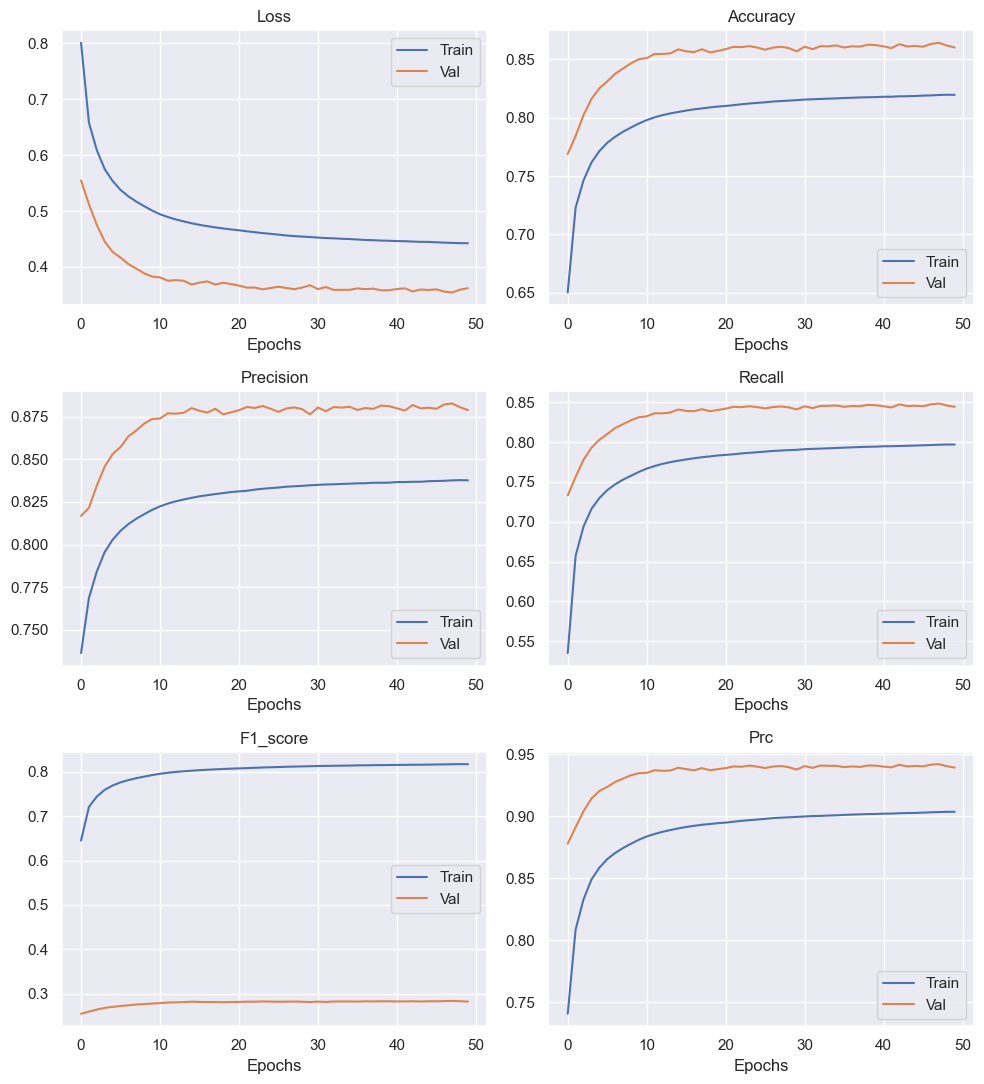

---- Last epoch loss ----
* Training:  0.442
* Validation:  0.362

---- Last epoch accuracy ----
* Training:  0.820
* Validation:  0.860

---- Last epoch precision ----
* Training:  0.838
* Validation:  0.879

---- Last epoch recall ----
* Training:  0.797
* Validation:  0.844

---- Last epoch f1_score ----
* Training:  0.817
* Validation:  0.282

---- Last epoch prc ----
* Training:  0.904
* Validation:  0.939



In [8]:
# conduct experiments and record results in an ablation table
model_exp = train_and_evaluate_ffnn(hidden_layer_sizes=[64],
                                    dropout_rate=0.05,
                                    learning_rate=0.001,
                                    batch_size=4096,
                                    num_epochs=50)

In [9]:
model_exp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_0 (Dense)                │ (None, 64)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_0 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,942 (81.81 KB)

 Trainable params: 6,980 (27.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,962 (54.54 KB)

In [10]:
# report the hyperparameter values for the prefered architecture configuration

print("""The hyperparameter values for prefered architecture configuration are:
      - hidden sizes: [64]
      - activation: relu
      - optimizer: Adam
      - learning rate: 0.001
      - number of epochs: 50
      - dropout rate: 0.05
      - batch_size: 4096
""")

The hyperparameter values for prefered architecture configuration are:
      - hidden sizes: [64]
      - activation: relu
      - optimizer: Adam
      - learning rate: 0.001
      - number of epochs: 50
      - dropout rate: 0.05
      - batch_size: 4096



In [11]:
# run the model once more using the preferred hyperparameter configuration

# define parameters
n_features = X_train_res_std.shape[1]
hidden_layer_sizes_preferred = [64]
activation_preferred = 'relu'
optimizer_preferred = 'Adam'
dropout_rate_preferred = 0.05
learning_rate_preferred = 0.001
num_epochs_preferred = 50
batch_size_preferred = 4096

# run the model
model_tf = build_model_ffnn(n_classes=4,
                        n_features = n_features,
                        hidden_layer_sizes=hidden_layer_sizes_preferred,
                        activation=activation_preferred,
                        optimizer=optimizer_preferred,
                        dropout_rate= dropout_rate_preferred,
                        metric=METRICS,
                        learning_rate=learning_rate_preferred)

model_fit_tf = model_tf.fit(x=X_train_res_std,
        y=Y_train_oh,
        epochs=num_epochs_preferred,
        batch_size=batch_size_preferred,
        validation_data=[X_val_std, Y_val_oh],
        verbose=0)

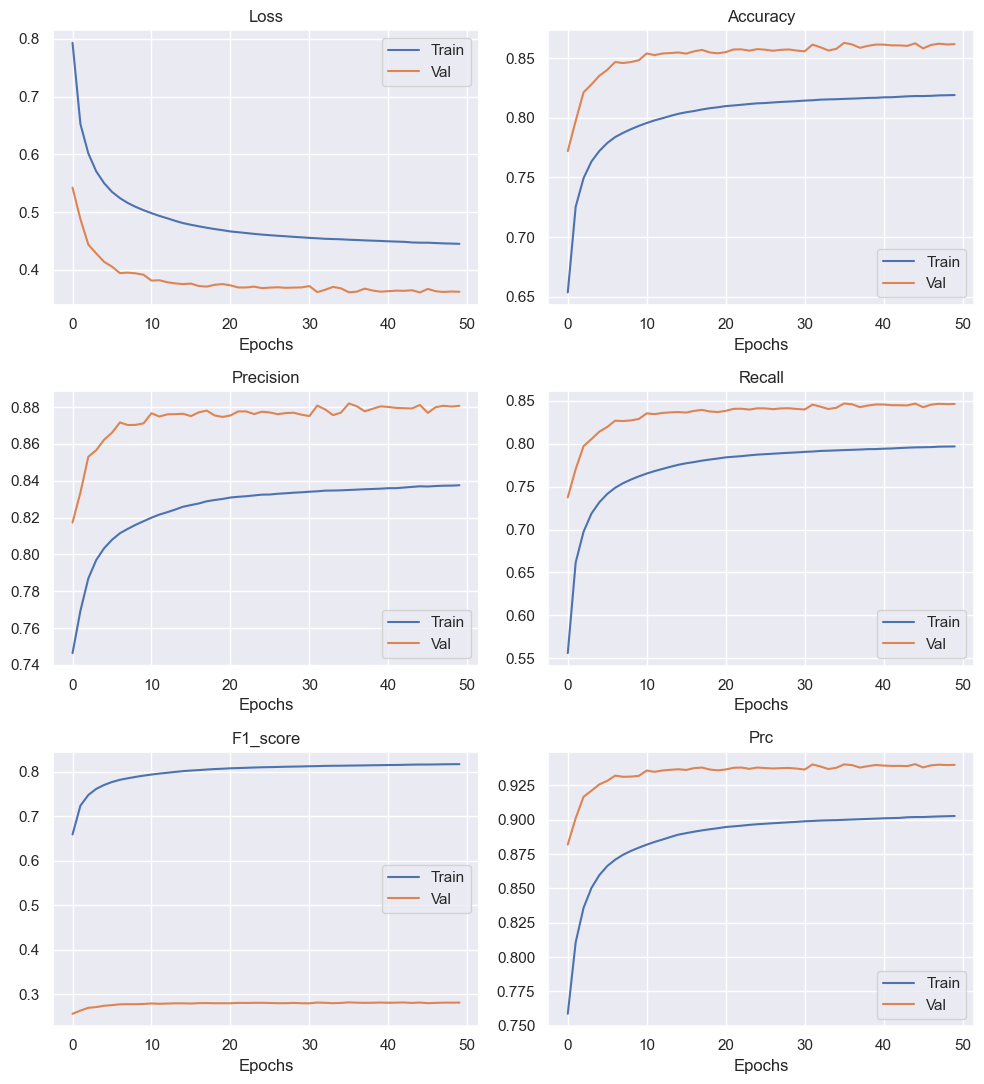

In [12]:
# plot history metrics
plot_history_metrics(model_fit_tf)

## Evaluate

In [13]:
Y_val_pred_proba = model_tf.predict(X_val_std) # predicted probability 
Y_val_pred = np.argmax(Y_val_pred_proba, axis=1)

print(f"Shape of Y_val: {Y_val.shape}")
print(f"Shape of Y_val_pred: {Y_val_pred.shape}")

14391/14391 ━━━━━━━━━━━━━━━━━━━━ 3s 229us/step
Shape of Y_val: (460504,)
Shape of Y_val_pred: (460504,)


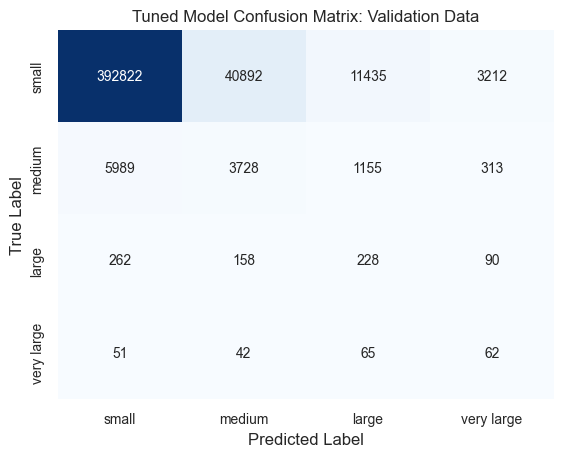

In [14]:
# plot the confusion matrix using (y_val, y_val_pred) data
target_labels = ['small', 'medium', 'large', 'very large']          

cf = tf.math.confusion_matrix(Y_val, Y_val_pred)
ax = sns.heatmap(cf, annot=True, fmt='d', cmap='Blues',
                 cbar=False,
                 annot_kws={'fontsize': 10},
                 xticklabels=target_labels,
                 yticklabels=target_labels)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set(xlabel='Predicted Label', ylabel='True Label')
ax.set_title('Tuned Model Confusion Matrix: Validation Data')
plt.show()

In [15]:
# adjust threshold
threshold = [0, 0.4, -0.2, -0.5]
Y_val_pred_adj = np.argmax(Y_val_pred_proba - threshold, axis=1)

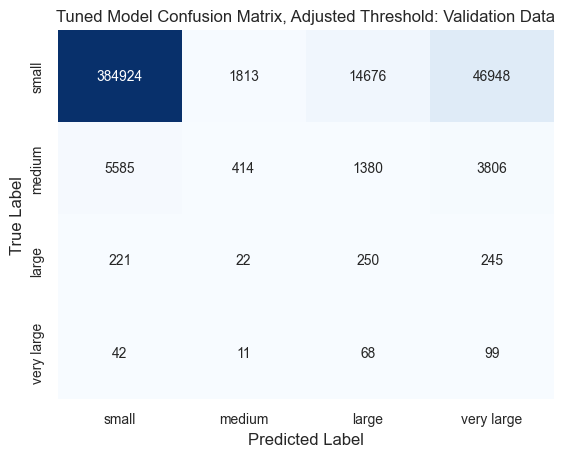

In [16]:
# plot the confusion matrix using (y_val, y_val_pred) data, with adjusted threshold
target_labels = ['small', 'medium', 'large', 'very large']          

cf = tf.math.confusion_matrix(Y_val, Y_val_pred_adj)
ax = sns.heatmap(cf, annot=True, fmt='d', cmap='Blues',
                 cbar=False,
                 annot_kws={'fontsize': 10},
                 xticklabels=target_labels,
                 yticklabels=target_labels)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set(xlabel='Predicted Label', ylabel='True Label')
ax.set_title('Tuned Model Confusion Matrix, Adjusted Threshold: Validation Data')
plt.show()

In [17]:
def print_report(fitted_clf, X, Y, txt = 'Data', threshold=[0,0,0,0]):
    target_labels = ['small', 'medium', 'large', 'very large']
    Y_pred_proba = fitted_clf.predict(X)
    Y_pred = np.argmax(Y_pred_proba - threshold, axis=1)
    print(f"\n*** {txt} ***")
    print(classification_report(Y, Y_pred, target_names=target_labels, digits=5))

In [18]:
print_report(model_tf, X=X_train_res_std, Y=Y_train_resampled, txt="FFNN (Training Data)")
print_report(model_tf, X=X_val_std, Y=Y_val, txt="FFNN (Validation Data)")

168136/168136 ━━━━━━━━━━━━━━━━━━━━ 39s 233us/step

*** FFNN (Training Data) ***
              precision    recall  f1-score   support

       small    0.86031   0.87797   0.86905   1345082
      medium    0.78829   0.67748   0.72870   1345082
       large    0.78349   0.83543   0.80863   1345082
  very large    0.90635   0.95505   0.93006   1345082

    accuracy                        0.83648   5380328
   macro avg    0.83461   0.83648   0.83411   5380328
weighted avg    0.83461   0.83648   0.83411   5380328

14391/14391 ━━━━━━━━━━━━━━━━━━━━ 3s 230us/step

*** FFNN (Validation Data) ***
              precision    recall  f1-score   support

       small    0.98421   0.87613   0.92703    448361
      medium    0.08318   0.33330   0.13313     11185
       large    0.01770   0.30894   0.03348       738
  very large    0.01686   0.28182   0.03182       220

    accuracy                        0.86175    460504
   macro avg    0.27549   0.45005   0.28136    460504
weighted avg    0.96031   

In [19]:
print_report(model_tf, X=X_train_res_std, Y=Y_train_resampled, threshold=threshold, txt="FFNN (Training Data, Threshold Adjusted)")
print_report(model_tf, X=X_val_std, Y=Y_val, threshold=threshold, txt="FFNN (Validation Data, Threshold Adjusted)")

168136/168136 ━━━━━━━━━━━━━━━━━━━━ 39s 229us/step

*** FFNN (Training Data, Threshold Adjusted) ***
              precision    recall  f1-score   support

       small    0.87329   0.86069   0.86694   1345082
      medium    0.97407   0.28874   0.44544   1345082
       large    0.75445   0.84541   0.79734   1345082
  very large    0.61582   0.98373   0.75747   1345082

    accuracy                        0.74464   5380328
   macro avg    0.80441   0.74464   0.71680   5380328
weighted avg    0.80441   0.74464   0.71680   5380328

14391/14391 ━━━━━━━━━━━━━━━━━━━━ 3s 224us/step

*** FFNN (Validation Data, Threshold Adjusted) ***
              precision    recall  f1-score   support

       small    0.98503   0.85851   0.91743    448361
      medium    0.18319   0.03701   0.06158     11185
       large    0.01527   0.33875   0.02922       738
  very large    0.00194   0.45000   0.00386       220

    accuracy                        0.83753    460504
   macro avg    0.29636   0.42107   0.25